In [1]:
import sys
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 20

from core.utils import visualization
from core.module_unet import UnetCascade
from core.module_gan import SRResNet

unet_div2k = UnetCascade.load_from_checkpoint('lightning_logs/rain_128/unetcascade/version_0/checkpoints/epoch=29-val_loss=0.0101.ckpt', map_location='cuda').cuda()
srresnet = SRResNet.load_from_checkpoint('lightning_logs/rain_128/srresnet/version_1/checkpoints/epoch=48-val_loss=0.0096.ckpt', map_location='cuda').cuda()

In [2]:
cap = cv2.VideoCapture('data/target.mp4')
video_arr = []
i = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        video_arr.append(frame)

        print(f'{i}: {ret}', end='\r')
        sys.stdout.flush()    
        i += 1
    else:
        break

cap.release()

In [3]:
video_np = np.array(video_arr)
video_np = np.pad(video_np, ((0, 0), (1, 1), (0, 0), (0, 0))) # needs to be divisible by 8
video_np = video_np.transpose(0, 3, 1, 2)
video_np.shape

(144, 3, 272, 480)

In [4]:
def upscale(model, video_np):
    upscaled = []

    for frame in tqdm(video_np):
        x = model.predict(frame)
        upscaled.append(x)

    upscaled = np.stack(upscaled)
    upscaled = upscaled[:, :, 4:-4] # crop to full hd
    
    return upscaled

upscaled_unet = upscale(unet_div2k, video_np)
upscaled_srresnet = upscale(srresnet, video_np)

100%|██████████| 144/144 [00:18<00:00,  7.89it/s]


In [32]:
upscaled = upscaled.transpose(0, 2, 3, 1)
upscaled.shape

(144, 1080, 1920, 3)

In [50]:
upscaled = upscaled.transpose(0, 3, 1, 2)
upscaled.shape

(144, 3, 1080, 1920)

In [6]:
out = cv2.VideoWriter('data/output_unet_div2k.mp4', cv2.VideoWriter_fourcc(*'FMP4'), 24, (1920, 1080))

upscaled = upscaled_unet.transpose(0, 2, 3, 1)

for frame in tqdm(upscaled):
    _frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(_frame)

out.release()

100%|██████████| 144/144 [00:02<00:00, 55.58it/s]


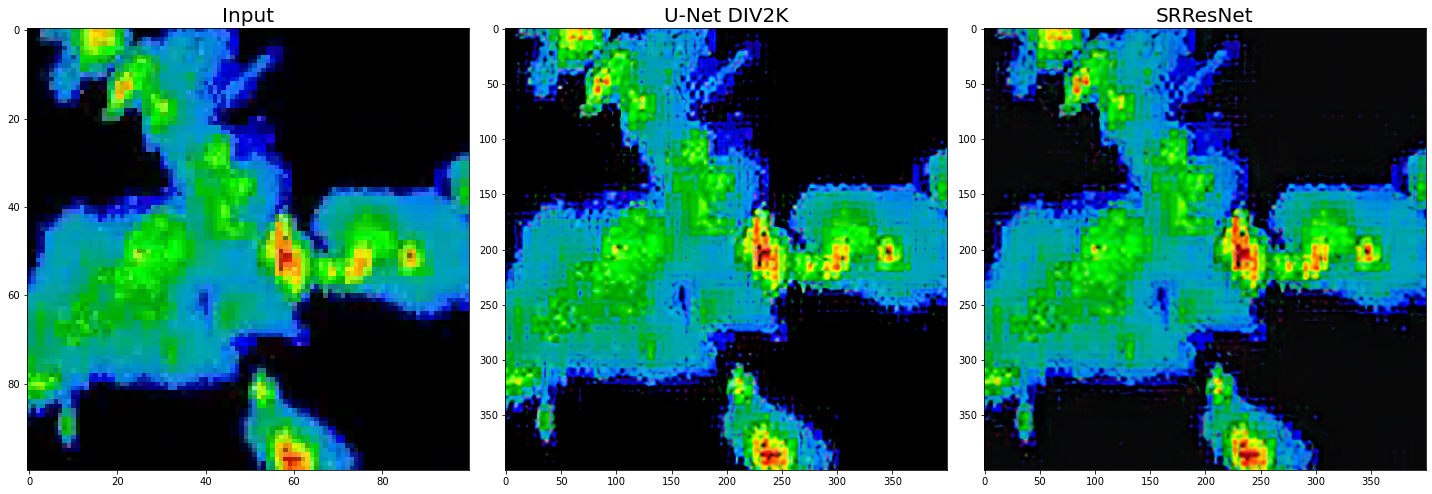

In [10]:
plt.figure(figsize=(20, 10)) # figsize is in inches

plt.subplot(131)
visualization.show(video_np[91, :, 75:175, 100:200], fig=False, title='Input')

plt.subplot(132)
visualization.show(upscaled_unet[91, :, 300:700, 400:800], fig=False, title='U-Net DIV2K')

plt.subplot(133)
visualization.show(upscaled_srresnet[91, :, 300:700, 400:800], fig=False, title='SRResNet')

plt.tight_layout()
plt.savefig('imgs/frame_sr.png')

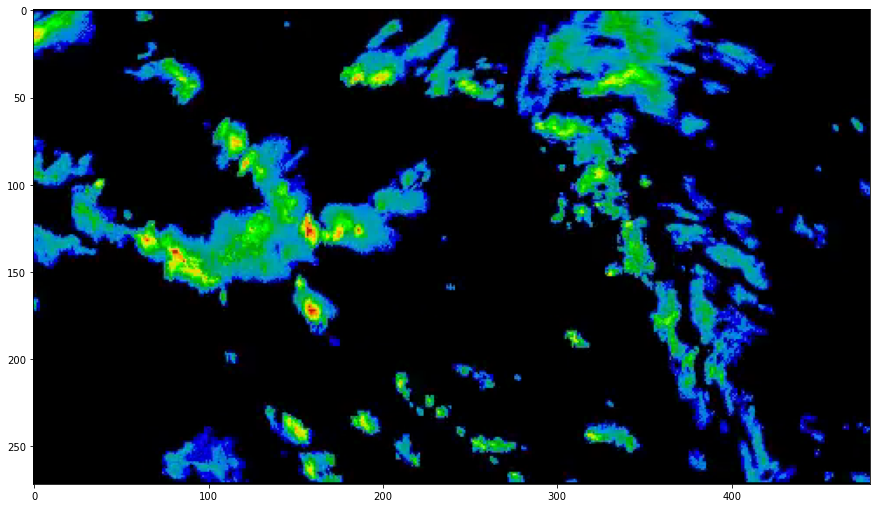

In [9]:
visualization.show(video_np[91])
plt.savefig('imgs/frame.png')